In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from operator import itemgetter
from sklearn.metrics import roc_auc_score

In [2]:
# Load dataset paths (update the paths to your actual dataset locations)
data_train_path = 'path_to_your_data/blood-train.csv'
data_test_path = 'path_to_your_data/blood-test.csv'
data_format_path = 'path_to_your_data/blood-format.csv'


In [3]:
data_train_path = 'C:/data/blood-train.csv'
data_test_path = 'C:/data/blood-test.csv'
data_format_path = 'C:/data/blood-format.csv'


In [4]:
test_data = pd.read_csv('blood-test.csv')
print(test_data.head())

   Unnamed: 0  Months since Last Donation  Number of Donations  \
0         659                           2                   12   
1         276                          21                    7   
2         263                           4                    1   
3         303                          11                   11   
4          83                           4                   12   

   Total Volume Donated (c.c.)  Months since First Donation  
0                         3000                           52  
1                         1750                           38  
2                          250                            4  
3                         2750                           38  
4                         3000                           34  


In [5]:
train_data = pd.read_csv('blood-train.csv')
print(train_data.head()) 

   Unnamed: 0  Months since Last Donation  Number of Donations  \
0         619                           2                   50   
1         664                           0                   13   
2         441                           1                   16   
3         160                           2                   20   
4         358                           1                   24   

   Total Volume Donated (c.c.)  Months since First Donation  \
0                        12500                           98   
1                         3250                           28   
2                         4000                           35   
3                         5000                           45   
4                         6000                           77   

   Made Donation in March 2007  
0                            1  
1                            1  
2                            1  
3                            1  
4                            0  


In [6]:
# Clean and prepare the datasets (adjust for the actual dataset columns)
train_data.rename(columns={'Made Donation in March 2007': 'target'}, inplace=True)  # Adjust if column name differs
test_data.rename(columns={'Made Donation in March 2007': 'target'}, inplace=True)  # Adjust if column name differs


In [7]:
# Check if renaming was successful
print(f"Train Data Columns: {train_data.columns}")
print(f"Test Data Columns: {test_data.columns}")


Train Data Columns: Index(['Unnamed: 0', 'Months since Last Donation', 'Number of Donations',
       'Total Volume Donated (c.c.)', 'Months since First Donation', 'target'],
      dtype='object')
Test Data Columns: Index(['Unnamed: 0', 'Months since Last Donation', 'Number of Donations',
       'Total Volume Donated (c.c.)', 'Months since First Donation'],
      dtype='object')


In [8]:
train_data.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')  # Adjust if other unwanted columns exist
test_data.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')  # Adjust if other unwanted columns exist

In [9]:

# Proceed with splitting the features and target columns
X_train = train_data.drop(columns='target')
y_train = train_data['target']

In [10]:
# Inspect variance to identify high variance columns
variance = X_train.var().round(3)
print("Feature Variance:\n", variance)


Feature Variance:
 Months since Last Donation          66.838
Number of Donations                 32.948
Total Volume Donated (c.c.)    2059232.337
Months since First Donation        586.980
dtype: float64


In [11]:
# Apply log normalization to reduce variance for high-variance columns (if needed) only on X_train
if 'Monetary (c.c. blood)' in X_train.columns:  # Check if the column exists in X_train
    col_to_normalize = 'Monetary (c.c. blood)'  # The column to normalize
    X_train_normed = X_train.copy()  # Create a copy of X_train for normalization
    X_train_normed['monetary_log'] = np.log(X_train_normed[col_to_normalize] + 1)  # Apply log transformation safely
    X_train_normed.drop(columns=col_to_normalize, inplace=True)  # Drop the original column after normalization
else:
    X_train_normed = X_train  # If no normalization is needed, use the original X_train

# Now create the target variable y_train (the same as previously)
y_train = train_data['target']

# The outputs (features) are X_train_normed and y_train (target variable)
print("Normalized Training Features:")
print(X_train_normed.head())  # Show the first few rows of the normalized training data
print("\nTarget Variable:")
print(y_train.head())  # Show the first few rows of the target variable


Normalized Training Features:
   Months since Last Donation  Number of Donations  \
0                           2                   50   
1                           0                   13   
2                           1                   16   
3                           2                   20   
4                           1                   24   

   Total Volume Donated (c.c.)  Months since First Donation  
0                        12500                           98  
1                         3250                           28  
2                         4000                           35  
3                         5000                           45  
4                         6000                           77  

Target Variable:
0    1
1    1
2    1
3    1
4    0
Name: target, dtype: int64


In [12]:
#Check the variance after normalization
normalized_variance = X_train_normed.var().round(3)
print("Normalized Feature Variance:\n", normalized_variance)

Normalized Feature Variance:
 Months since Last Donation          66.838
Number of Donations                 32.948
Total Volume Donated (c.c.)    2059232.337
Months since First Donation        586.980
dtype: float64


In [13]:
# Model Selection using RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=2)
grid_search.fit(X_train_normed, y_train)

best_rf = grid_search.best_estimator_

# Assuming best_rf is already trained with grid_search
rf_auc_score_train = roc_auc_score(y_train, best_rf.predict_proba(X_train_normed)[:, 1])
print(f'\nRandom Forest AUC score (on training data): {rf_auc_score_train:.4f}')


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_de

In [14]:
# Train logistic regression model
logreg = linear_model.LogisticRegression(solver='liblinear', random_state=42)
logreg.fit(X_train_normed, y_train)


# Assuming best_rf is already trained with grid_search
rf_auc_score_train = roc_auc_score(y_train, best_rf.predict_proba(X_train_normed)[:, 1])
print(f'\nRandom Forest AUC score (on training data): {rf_auc_score_train:.4f}')
# Train logistic regression model
logreg = linear_model.LogisticRegression(solver='liblinear', random_state=42)
logreg.fit(X_train_normed, y_train)

# Calculate AUC score on training data (since we can't use y_test)
logreg_auc_score_train = roc_auc_score(y_train, logreg.predict_proba(X_train_normed)[:, 1])
print(f'\nLogistic Regression AUC score (on training data): {logreg_auc_score_train:.4f}')




Random Forest AUC score (on training data): 0.8853

Logistic Regression AUC score (on training data): 0.7488


In [15]:
# Assuming you have the Random Forest AUC score already calculated
# You need to define rf_auc_score first by using grid_search

best_rf = grid_search.best_estimator_

# Assuming you already have X_train_normed, y_train, and X_test_normed
rf_auc_score_train = roc_auc_score(y_train, best_rf.predict_proba(X_train_normed)[:, 1])

# Logistic Regression AUC score
logreg_auc_score_train = roc_auc_score(y_train, logreg.predict_proba(X_train_normed)[:, 1])

# Now compare the models
model_comparison = sorted(
    [("Random Forest", rf_auc_score_train), ("Logistic Regression", logreg_auc_score_train)],
    key=itemgetter(1),
    reverse=True
)

print("\nModel Comparison (sorted by AUC):")
for model_name, auc_score in model_comparison:
    print(f"{model_name}: AUC = {auc_score:.4f}")



Model Comparison (sorted by AUC):
Random Forest: AUC = 0.8853
Logistic Regression: AUC = 0.7488



Model Comparison (sorted by AUC):
Random Forest: AUC = 0.8853
Logistic Regression: AUC = 0.7488


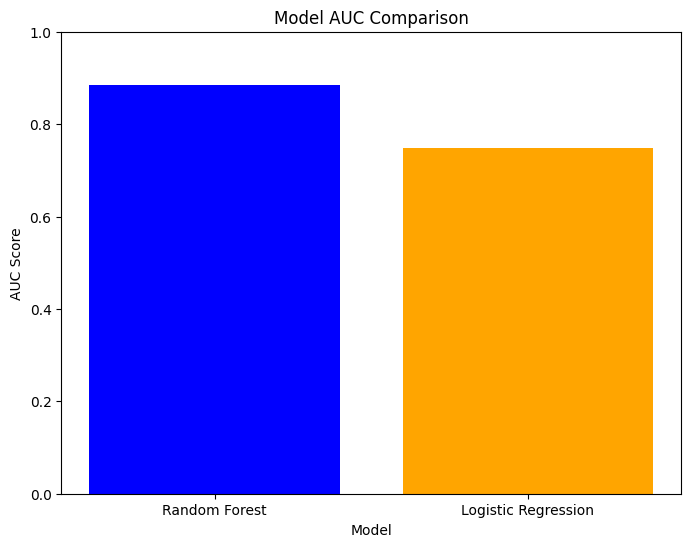

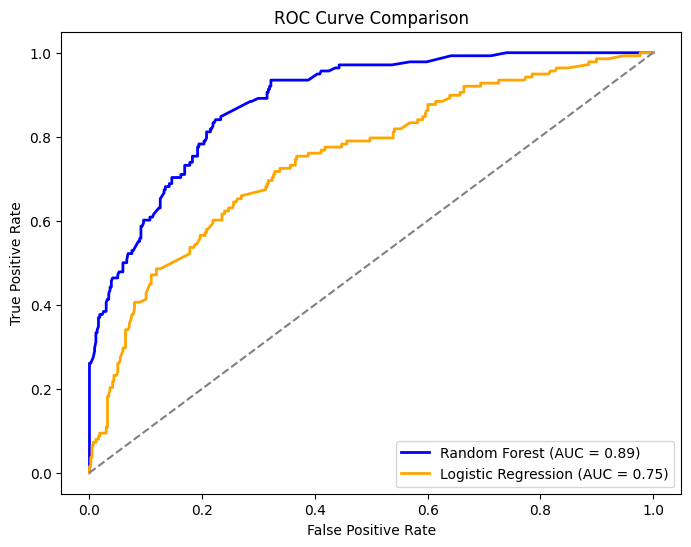

In [16]:
est_rf = grid_search.best_estimator_

# Calculate AUC score for Random Forest and Logistic Regression
rf_auc_score_train = roc_auc_score(y_train, best_rf.predict_proba(X_train_normed)[:, 1])
logreg_auc_score_train = roc_auc_score(y_train, logreg.predict_proba(X_train_normed)[:, 1])

# Now compare the models
model_comparison = sorted(
    [("Random Forest", rf_auc_score_train), ("Logistic Regression", logreg_auc_score_train)],
    key=itemgetter(1),
    reverse=True
)

# Model comparison output
print("\nModel Comparison (sorted by AUC):")
for model_name, auc_score in model_comparison:
    print(f"{model_name}: AUC = {auc_score:.4f}")

# Plot AUC scores for model comparison
plt.figure(figsize=(8, 6))
model_names = [model_name for model_name, _ in model_comparison]
auc_scores = [auc_score for _, auc_score in model_comparison]
plt.bar(model_names, auc_scores, color=['blue', 'orange'])
plt.title('Model AUC Comparison')
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.ylim(0, 1)
plt.show()

# ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_train, best_rf.predict_proba(X_train_normed)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# ROC Curve for Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_train, logreg.predict_proba(X_train_normed)[:, 1])
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_logreg, tpr_logreg, color='orange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()